# CICERO SCM notebook parallel example

Import some stuff and import the model

In [ ]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [3]:
# NBVAL_IGNORE_OUTPUT
#from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions
from ciceroscm.parallel.cscmparwrapper import run_ciceroscm_parallel
import ciceroscm.input_handler as input_handler

/home/obola/repositories/cicero-scm-surrogate/ciceroscm/notebooks/../src/ciceroscm/parallel/_parallel_process.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Define data directory

In [4]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

Define emissions data

In [5]:

gaspam_data = input_handler.read_components(
    os.path.join(test_data_dir, "gases_v1RCMIP.txt")
)
conc_data = input_handler.read_inputfile(
    os.path.join(test_data_dir, "ssp245_conc_RCMIP.txt"), True, 1750, 2100
)
ih = input_handler.InputHandler({"nyend": 2050, "nystart": 1900, "emstart": 2015})
em_data = ih.read_emissions(os.path.join(test_data_dir, "ssp245_em_RCMIP.txt"))
nat_ch4_data = input_handler.read_natural_emissions(
    os.path.join(test_data_dir, "natemis_ch4.txt"), "CH4"
)
nat_n2o_data = input_handler.read_natural_emissions(
    os.path.join(test_data_dir, "natemis_n2o.txt"), "N2O"
)

Make a list of dictionaries to define the parameter ensemble - keys should be pamset_udm, pamset_emiconc and Index...

In [14]:
cfgs = [
    {
        "pamset_udm": {
            "rlamdo": 15.1,
            "akapa": 0.657,
            "cpi": 0.208,
            "W": 2.2,
            "beto": 6.9,
            "lambda": 0.606,
            "mixed": 107.0,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.5,
            "qdirso2": -0.3701,
            "qindso2": -0.4163,
            "qbc": 0.163,
            "qoc": -0.084,
            "qh2o_ch4": 0.171,
        },
        "Index": "13555_old_NR_rounded",
    },
    {
        "pamset_udm": {
            "rlamdo": 15.08357,
            "akapa": 0.6568376339229769,
            "cpi": 0.2077266,
            "W": 2.205919,
            "beto": 6.89822,
            "lambda": 0.6062529,
            "mixed": 107.2422,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.5,
            "qdirso2": -0.3562,
            "qindso2": -0.96609,
            "qbc": 0.1566,
            "qoc": -0.0806,
        },
        "Index": "13555_old_NR_improved",
    },
    {
        "pamset_udm": {
            "rlamdo": 15.08357,
            "akapa": 0.6568376339229769,
            "cpi": 0.2077266,
            "W": 2.205919,
            "beto": 6.89822,
            "lambda": 0.6062529,
            "mixed": 107.2422,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.5,
            "qdirso2": -0.3701323367808028 / 1.5,
            "qindso2": -0.4162980444986502 * 1.5,
            "qbc": 0.162692563111132,
            "qoc": -0.08377713183167902,
        },
        "Index": "13555_old_NR",
    },
    {
        "pamset_udm": {
            "rlamdo": 5.269455,
            "akapa": 0.40099950002568496,
            "cpi": 0.2054687,
            "W": 1.95183,
            "beto": 3.278654,
            "lambda": 0.7308369,
            "mixed": 115.1219,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.3,
            "qdirso2": -0.32211222516087934,
            "qindso2": -0.3622885009449893,
            "qbc": 0.1415852070009452,
            "qoc": -0.07290808089507649,
        },
        "Index": "10496_old_NR",
    },
    {
        "pamset_udm": {
            "rlamdo": 5.269455,
            "akapa": 0.40099950002568496,
            "cpi": 0.2054687,
            "W": 1.95183,
            "beto": 3.278654,
            "lambda": 0.7308369,
            "mixed": 115.1219,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.3,
            "qdirso2": -0.32211222516087934,
            "qindso2": -0.3622885009449893,
            "qbc": 0.1415852070009452,
            "qoc": -0.07290808089507649,
        },
        "Index": "10974_old_NR",
    },
    {
        "pamset_udm": {
            "rlamdo": 23.71469,
            "akapa": 0.5486541129586187,
            "cpi": 0.4059296,
            "W": 2.090927,
            "beto": 4.426507,
            "lambda": 0.6345007,
            "mixed": 97.25478,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.3,
            "qdirso2": -0.4031202924043847,
            "qindso2": -0.453400507735301,
            "qbc": 0.17719249872571508,
            "qoc": -0.09124374858602939,
        },
        "Index": "Unknown_old_NR",
    },
    {
        "pamset_udm": {
            "rlamdo": 23.13088,
            "akapa": 0.6588532950589802,
            "cpi": 0.1690946,
            "W": 2.228695,
            "beto": 2.623041,
            "lambda": 0.5402487,
            "mixed": 99.86714,
        },
        "pamset_emiconc": {
            "qbmb": 0.0,
            "qo3": 0.3,
            "qdirso2": -0.882827534329248,
            "qindso2": -0.9929404692583796,
            "qbc": 0.3880489761967636,
            "qoc": -0.1998224726091362,
        },
        "Index": "28925_old_NR",
    },
]

Define scenarios as a list of dictionaries.

In [15]:
scenarios=[]
for i in range(3):
    em_data_here = em_data.mul((1 + i / 5))
    new_scen = {
        "gaspam_data": gaspam_data,
        "nyend": 2050,
        "nystart": 1900,
        "emstart": 2015,
        "concentrations_data": conc_data,
        "nat_ch4_data": nat_ch4_data,
        "nat_n2o_data": nat_n2o_data,
        "emissions_data": em_data_here,
        "udir": test_data_dir,
        "idtm":24,
        "scenname": "ssp245-plus-%d-percent" % np.multiply(i,20.),
    }
    scenarios.append(new_scen)
    
    

Parallel processor loops over all scenarios and configuration lists

In [16]:
# NBVAL_IGNORE_OUTPUT
output_variables = ["Heat Content|Ocean", "Surface Air Temperature Change"]
results = run_ciceroscm_parallel(scenarios, cfgs, output_variables)


Parallel runs:   0%|          | 0.00/6.00 [00:00<?, ?it/s]

Look at the output openSCMrunner object

In [18]:
# NBVAL_IGNORE_OUTPUT
results

,climate_model,model,run_id,scenario,region,variable,unit,1900,1901,1902,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,CICERO-SCM-PY,ssp245-plus-0-percent,13555_old_NR_rounded,ssp245-plus-0-percent,World,Heat Content|Ocean,ZJ,-0.593835,-1.570286,-2.381085,...,882.279889,896.27472,910.128435,923.829002,937.366761,950.733705,963.923257,976.930068,989.749828,1002.379128
1,CICERO-SCM-PY,ssp245-plus-0-percent,13555_old_NR_rounded,ssp245-plus-0-percent,World,Surface Air Temperature Change,K,-0.005125,-0.012324,-0.014943,...,1.604634,1.617487,1.629858,1.641679,1.652929,1.663597,1.673684,1.683194,1.692137,1.700522
2,CICERO-SCM-PY,ssp245-plus-0-percent,13555_old_NR_improved,ssp245-plus-0-percent,World,Heat Content|Ocean,ZJ,-0.593855,-1.606135,-2.505708,...,698.360017,712.877458,727.293003,741.593854,755.769661,769.811787,783.713067,797.4676,811.070548,824.518001
3,CICERO-SCM-PY,ssp245-plus-0-percent,13555_old_NR_improved,ssp245-plus-0-percent,World,Surface Air Temperature Change,K,-0.005126,-0.012631,-0.015937,...,1.412663,1.428602,1.444106,1.459105,1.473571,1.487491,1.500863,1.513691,1.525979,1.537739
4,CICERO-SCM-PY,ssp245-plus-0-percent,13555_old_NR,ssp245-plus-0-percent,World,Heat Content|Ocean,ZJ,-0.593855,-1.577005,-2.404635,...,842.875677,856.8558,870.702628,884.40415,897.950716,911.334313,924.548352,937.587462,950.447298,963.124411
5,CICERO-SCM-PY,ssp245-plus-0-percent,13555_old_NR,ssp245-plus-0-percent,World,Surface Air Temperature Change,K,-0.005126,-0.012378,-0.015122,...,1.558513,1.571799,1.584615,1.596895,1.608616,1.619768,1.63035,1.640367,1.649826,1.65874
6,CICERO-SCM-PY,ssp245-plus-0-percent,10496_old_NR,ssp245-plus-0-percent,World,Heat Content|Ocean,ZJ,-0.505329,-1.352405,-2.069332,...,809.981508,824.022376,838.004066,851.918175,865.757609,879.516267,893.18893,906.771162,920.259199,933.649869
7,CICERO-SCM-PY,ssp245-plus-0-percent,10496_old_NR,ssp245-plus-0-percent,World,Surface Air Temperature Change,K,-0.010207,-0.020614,-0.021996,...,1.893477,1.912415,1.93088,1.948835,1.966277,1.983206,1.999628,2.015552,2.030987,2.045946
8,CICERO-SCM-PY,ssp245-plus-0-percent,10974_old_NR,ssp245-plus-0-percent,World,Heat Content|Ocean,ZJ,-0.505329,-1.352405,-2.069332,...,809.981508,824.022376,838.004066,851.918175,865.757609,879.516267,893.18893,906.771162,920.259199,933.649869
9,CICERO-SCM-PY,ssp245-plus-0-percent,10974_old_NR,ssp245-plus-0-percent,World,Surface Air Temperature Change,K,-0.010207,-0.020614,-0.021996,...,1.893477,1.912415,1.93088,1.948835,1.966277,1.983206,1.999628,2.015552,2.030987,2.045946


Plot some plume plots, showing the range of temperature for each scenario (looking at percentiles of the parameter response distribution)

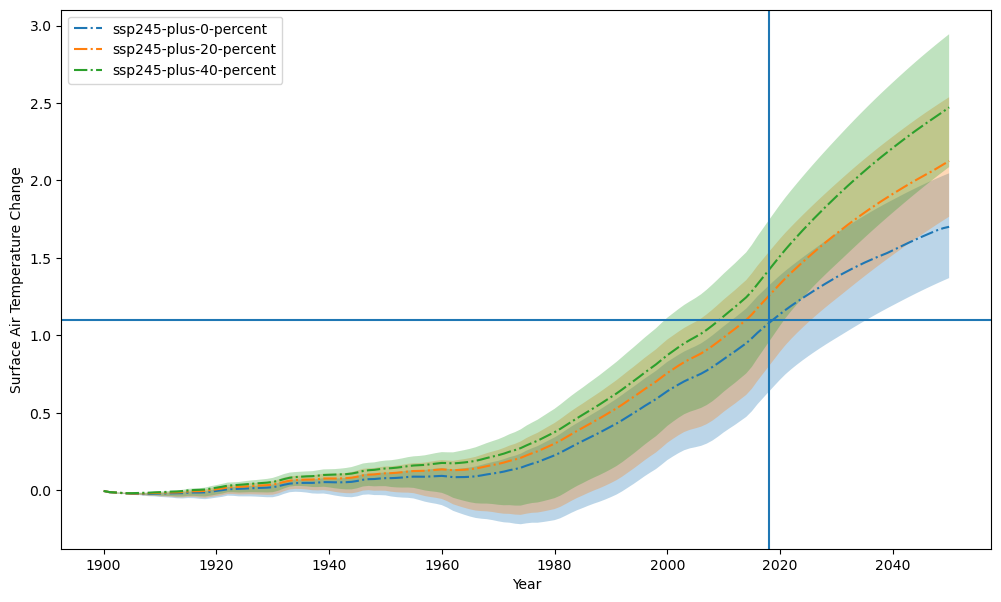

In [10]:

# NBVAL_IGNORE_OUTPUT
ax = plt.figure(figsize=(12, 7)).add_subplot(111)
for name, group in results[results["variable"]=="Surface Air Temperature Change"].groupby("scenario"):
    ax.plot(group.columns[7:], group.iloc[:, 7:].quantile(0.5), '-.', label = name)
    ax.fill_between(group.columns[7:].astype(int), group.iloc[:, 7:].quantile(0.05).astype(float), group.iloc[:, 7:].quantile(0.95).astype(float), alpha = 0.3)

ax.set_xlabel("Year")
ax.set_ylabel("Surface Air Temperature Change")
ax.legend()
ax.axhline(1.1)
ax.axvline(2018)
